In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("aqi1.csv")
data.columns

Index(['City', 'Date', 'PM2.5', 'PM10', 'NO2', 'NH3', 'CO', 'SO2', 'O3', 'AQI',
       'AQI_Bucket'],
      dtype='object')

In [3]:
dt1=data[['Date','AQI']]
dt1.head()


,Date,AQI
0,12-03-2020,52
1,13-03-2020,60
2,14-03-2020,62
3,15-03-2020,70
4,16-03-2020,54


C:\Users\kunja\AppData\Local\Temp\ipykernel_10080\1829244946.py:1: UserWarning: Parsing '13-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dt1['Date'] = pd.to_datetime(dt1['Date'], infer_datetime_format=True)
C:\Users\kunja\AppData\Local\Temp\ipykernel_10080\1829244946.py:1: UserWarning: Parsing '14-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dt1['Date'] = pd.to_datetime(dt1['Date'], infer_datetime_format=True)
C:\Users\kunja\AppData\Local\Temp\ipykernel_10080\1829244946.py:1: UserWarning: Parsing '15-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dt1['Date'] = pd.to_datetime(dt1['Date'], infer_datetime_format=True)
C:\Users\kunja\AppData\Local\Temp\ipykernel_10080\1829244946.py:1: UserWarning: Parsing '16-03-2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for cons

C:\Users\kunja\AppData\Local\Temp\ipykernel_10080\1829244946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt1['Date'] = pd.to_datetime(dt1['Date'], infer_datetime_format=True)


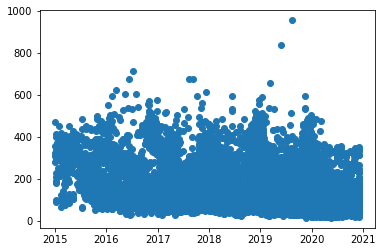

In [4]:
dt1['Date'] = pd.to_datetime(dt1['Date'], infer_datetime_format=True)
plt.scatter(dt1['Date'],dt1['AQI'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'AQI(t-{i})'] = df['AQI'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(dt1, lookback)
shifted_df.head()

,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7)
Date,,,,,,,,
2020-03-19,63,51.0,40.0,54.0,70.0,62.0,60.0,52.0
2020-03-20,69,63.0,51.0,40.0,54.0,70.0,62.0,60.0
2020-03-21,70,69.0,63.0,51.0,40.0,54.0,70.0,62.0
2020-03-22,71,70.0,69.0,63.0,51.0,40.0,54.0,70.0
2020-03-23,53,71.0,70.0,69.0,63.0,51.0,40.0,54.0


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 63.,  51.,  40., ...,  62.,  60.,  52.],
       [ 69.,  63.,  51., ...,  70.,  62.,  60.],
       [ 70.,  69.,  63., ...,  54.,  70.,  62.],
       ...,
       [ 68.,  70.,  41., ...,  86., 100.,  95.],
       [ 54.,  68.,  70., ...,  77.,  86., 100.],
       [ 50.,  54.,  68., ...,  47.,  77.,  86.]])

In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming your array is named 'data'
scaler = StandardScaler()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[-0.77682807, -0.90737571, -1.02702228, ..., -0.78769963,
        -0.80947408, -0.89647359],
       [-0.71155494, -0.77682936, -0.907356  , ..., -0.70066909,
        -0.78771626, -0.80944356],
       [-0.70067608, -0.71155619, -0.77681096, ..., -0.87473016,
        -0.70068498, -0.78768605],
       ...,
       [-0.72243379, -0.70067732, -1.01614353, ..., -0.52660803,
        -0.37431766, -0.42868716],
       [-0.87473776, -0.72243505, -0.70065969, ..., -0.62451738,
        -0.52662241, -0.37429339],
       [-0.91825318, -0.87473912, -0.7224172 , ..., -0.95088188,
        -0.6245326 , -0.52659595]])

In [8]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((14395, 7), (14395,))

In [9]:
X = dc(np.flip(X, axis=1))
X

array([[-0.89647359, -0.80947408, -0.78769963, ..., -0.87470177,
        -1.02702228, -0.90737571],
       [-0.80944356, -0.78771626, -0.70066909, ..., -1.02700302,
        -0.907356  , -0.77682936],
       [-0.78768605, -0.70068498, -0.87473016, ..., -0.90733775,
        -0.77681096, -0.71155619],
       ...,
       [-0.42868716, -0.37431766, -0.52660803, ..., -0.95085239,
        -1.01614353, -0.70067732],
       [-0.37429339, -0.52662241, -0.62451738, ..., -1.01612436,
        -0.70065969, -0.72243505],
       [-0.52659595, -0.6245326 , -0.95088188, ..., -0.70064319,
        -0.7224172 , -0.87473912]])

In [10]:
split_index = int(len(X) * 0.90)

split_index

12955

In [11]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12955, 7), (1440, 7), (12955,), (1440,))

In [12]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12955, 7, 1), (1440, 7, 1), (12955, 1), (1440, 1))

In [13]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([12955, 7, 1]),
 torch.Size([1440, 7, 1]),
 torch.Size([12955, 1]),
 torch.Size([1440, 1]))

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [15]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
# model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [18]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [19]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [20]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.869
Batch 200, Loss: 0.657
Batch 300, Loss: 0.451
Batch 400, Loss: 0.464
Batch 500, Loss: 0.365
Batch 600, Loss: 0.303
Batch 700, Loss: 0.357
Batch 800, Loss: 0.251

Val Loss: 0.118
***************************************************

Epoch: 2
Batch 100, Loss: 0.234
Batch 200, Loss: 0.259
Batch 300, Loss: 0.249
Batch 400, Loss: 0.191
Batch 500, Loss: 0.212
Batch 600, Loss: 0.212
Batch 700, Loss: 0.179
Batch 800, Loss: 0.178

Val Loss: 0.098
***************************************************

Epoch: 3
Batch 100, Loss: 0.225
Batch 200, Loss: 0.213
Batch 300, Loss: 0.190
Batch 400, Loss: 0.174
Batch 500, Loss: 0.176
Batch 600, Loss: 0.157
Batch 700, Loss: 0.159
Batch 800, Loss: 0.158

Val Loss: 0.091
***************************************************

Epoch: 4
Batch 100, Loss: 0.147
Batch 200, Loss: 0.154
Batch 300, Loss: 0.196
Batch 400, Loss: 0.150
Batch 500, Loss: 0.220
Batch 600, Loss: 0.155
Batch 700, Loss: 0.155
Batch 800, Loss: 0.177

Val Loss: 0.090
*

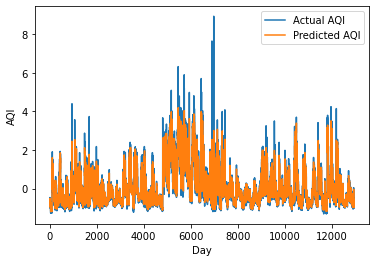

In [21]:
with torch.no_grad():
    predicted = model(X_train).numpy()

plt.plot(y_train, label='Actual AQI')
plt.plot(predicted, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [22]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([52.74285803, 60.84966916, 65.71908137, ..., 51.69056093,
       49.65387277, 45.66579266])

In [23]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([63.00000159, 68.99999955, 70.00000013, ..., 47.99999848,
       41.99999504, 47.99999848])

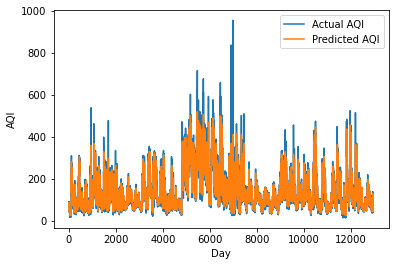

In [24]:
plt.plot(new_y_train, label='Actual AQI')
plt.plot(train_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [25]:
test_predictions = model(X_test).detach().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([48.79507008, 46.74315045, 49.08839087, ..., 69.70758884,
       67.04265199, 56.59832575])

In [26]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([45.00000224, 48.99999905, 49.99999963, ..., 67.99999898,
       54.00000192, 49.99999963])

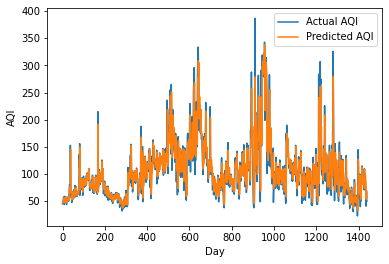

In [27]:
plt.plot(new_y_test, label='Actual AQI')
plt.plot(test_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [29]:
scripted_model = torch.jit.script(model)
scripted_model.save("aqi_forecasting.pt")